In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float64)

In [2]:
n = 200
nt = 100
k = 50
x = torch.distributions.uniform.Uniform(low=-1 * torch.ones(n), high=torch.ones(n)).sample()
x, _ = torch.sort(x)
x = x.unsqueeze(1)

In [3]:
z_dist = torch.distributions.normal.Normal(loc=0, scale=1)

In [4]:
torch.manual_seed(0)
p = torch.sigmoid(z_dist.sample() + z_dist.sample() * x + z_dist.sample() * x**2 -4)
phi = torch.sigmoid(z_dist.sample() + z_dist.sample() * x + z_dist.sample() * x**2 + 1)
gamma = torch.sigmoid(z_dist.sample() + z_dist.sample() * x + z_dist.sample() * x**2 -2)
psi0 = torch.sigmoid(z_dist.sample() + z_dist.sample() * x + z_dist.sample() * x**2 -3)

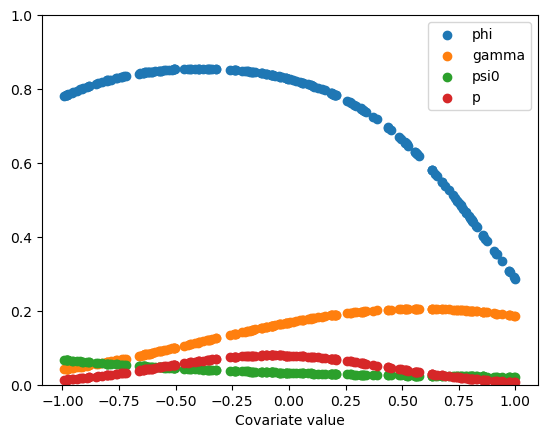

In [5]:
plt.scatter(x.numpy(), phi.numpy())
plt.scatter(x.numpy(), gamma.numpy())
plt.scatter(x.numpy(), psi0.numpy())
plt.scatter(x.numpy(), p.numpy())
plt.xlabel('Covariate value')
plt.ylabel('')
plt.ylim(0, 1)
plt.legend(['phi', 'gamma', 'psi0', 'p'])
plt.show()

In [6]:
z0 = torch.distributions.Bernoulli(probs = psi0).sample()

In [7]:
z = torch.zeros((n, nt))

In [8]:
z[:, 0] = z0.squeeze()

In [9]:
for t in range(1, nt):
    psi = z[:, t - 1] * phi.squeeze() + (1. - z[:, t - 1]) * gamma.squeeze()
    z[:, t] = torch.distributions.Bernoulli(probs = psi).sample()

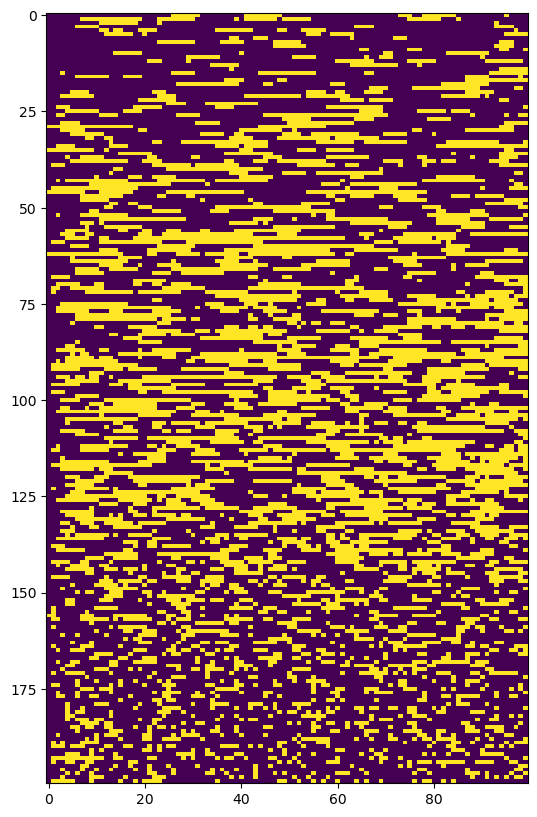

In [10]:
plt.figure(figsize = (7, 10))
plt.imshow(z.numpy(), aspect=.8)

In [11]:
y = torch.distributions.Binomial(total_count=k, probs=z * p).sample()

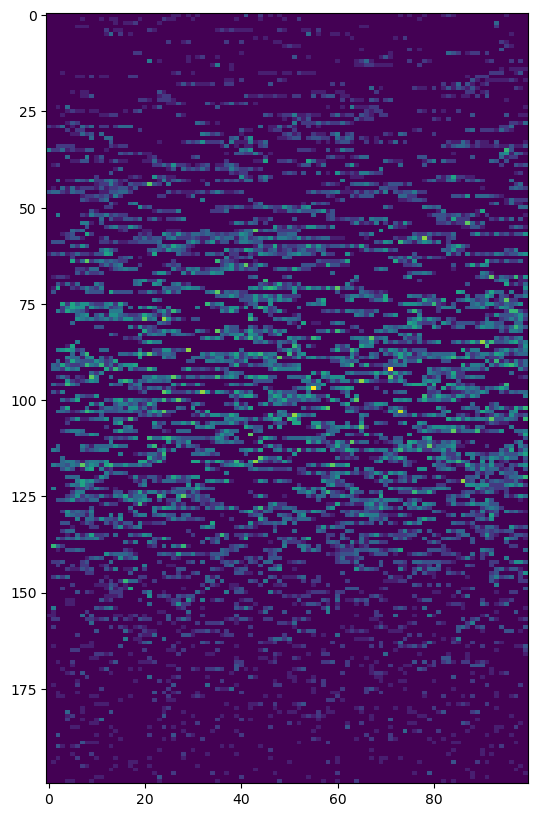

In [12]:
plt.figure(figsize = (7, 10))
plt.imshow(y.numpy(), aspect=.8)

## Define a model

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # affine operations: y = Wx + b
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 4)
        self.nt = nt

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        output = self.fc2(x)
        phi = torch.sigmoid(output[:, [0]].repeat(1, self.nt - 1))
        gamma = torch.sigmoid(output[:, [1]].repeat(1, self.nt - 1))
        psi0 = torch.sigmoid(output[:, [2]])
        logit_p = output[:, [3]].repeat(1, self.nt)

        return phi, gamma, psi0, logit_p

In [14]:
net = Net().to(device)
running_loss = list()

In [15]:
net

Net(
  (fc1): Linear(in_features=1, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=4, bias=True)
)

## Create a data loader

In [16]:
dataset = TensorDataset(x, y)
dataloader = DataLoader(dataset, 
                        batch_size=32,
                        shuffle=True, 
                        num_workers=6)

## Train the model

In [17]:
n_epoch = 100
optimizer = torch.optim.Adam(net.parameters(), weight_decay=1e-6)

In [18]:
def get_loglik2(y_j, psi0_j, gamma_j, phi_j, logit_p_j):
    """ Calculate log likelihood with scaled forward algorithm
    
    Some nice detail here: https://pdfs.semanticscholar.org/4ce1/9ab0e07da9aa10be1c336400c8e4d8fc36c5.pdf
    "Some mathematics for HMM" by Dawei Shen, October 13th, 2008
    """
    batch_size = y_j.shape[0]
    nt = y_j.shape[1]
    
    pr_y_present = torch.exp(torch.distributions.binomial.Binomial(total_count=k, logits=logit_p_j).log_prob(y_j))
    po = torch.stack((pr_y_present, (y_j==0).to(device, dtype=torch.float64)), -1) # nt, 2b
    phi_0_j = torch.cat((psi0_j, 1-psi0_j), -1)
    
    Omega = torch.stack((torch.stack((phi_j, 1 - phi_j), -1), 
                       torch.stack((gamma_j, 1 - gamma_j), -1)), 
                      -2) # dims: (batch_size, nt-1, 2, 2)
    assert Omega.shape == (batch_size, nt - 1, 2, 2)
    
    c = list()
    alpha_raw = torch.bmm(phi_0_j.unsqueeze(1), 
                          torch.diag_embed(po[:, 0, :], dim1=-2, dim2=-1)
                         )
    c.append((torch.ones(batch_size, 1).to(device) / torch.sum(alpha_raw, dim=-1)).squeeze())
    alpha = c[-1].view(-1, 1, 1) * alpha_raw
    
    for t in range(nt - 1):
        alpha_raw = torch.bmm(alpha, 
                          torch.bmm(
                              Omega[:, t, :, :], 
                              # batch diagonal
                              torch.diag_embed(po[:, t+1, :], dim1=-2, dim2=-1),
                            )
                         )
        c.append((torch.ones(batch_size, 1).to(device) / torch.sum(alpha_raw, dim=-1)).squeeze())
        alpha = c[-1].view(-1, 1, 1) * alpha_raw
    c_stacked = torch.stack(c, -1)
    return -torch.sum(torch.log(c_stacked), dim=-1)

In [19]:
for i in tqdm(range(n_epoch)):
    for i_batch, xy in enumerate(dataloader):
        x_i, y_i = xy
        x_i = x_i.to(device)
        y_i = y_i.to(device)
        optimizer.zero_grad()
        phi_i, gamma_i, psi0_i, logit_p_i, = net(x_i)

        # compute the negative log likliehood
        ll = get_loglik2(y_i, psi0_i, gamma_i, phi_i, logit_p_i)
        assert torch.sum(torch.isnan(ll)) < 1
        loss = -torch.mean(ll)        
        loss.backward()
        optimizer.step()    # Does the update
        running_loss.append(loss.cpu().data.numpy())

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:37<00:00,  2.67it/s]


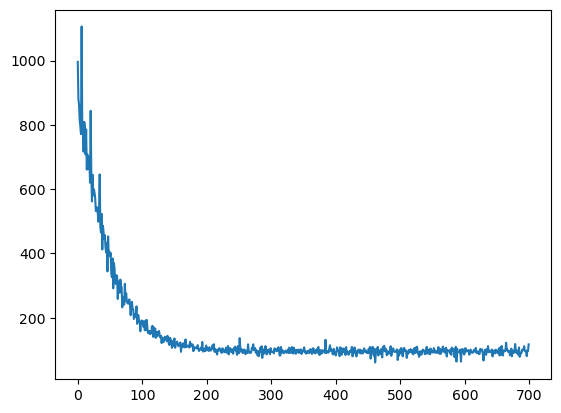

In [20]:
plt.plot([i for i in range(len(running_loss))], 
            np.array(running_loss), 
            alpha=1)

In [21]:
phi_hat, gamma_hat, psi0_hat, p_hat = net(x.to(device))

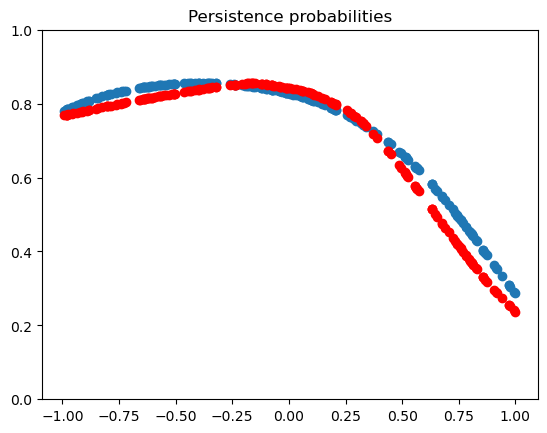

In [22]:
plt.scatter(x.numpy(), phi.numpy())
plt.scatter(x.numpy(), phi_hat[:, 0].cpu().detach().numpy(), color='r')
plt.title('Persistence probabilities')
plt.ylim(0, 1)
plt.show()

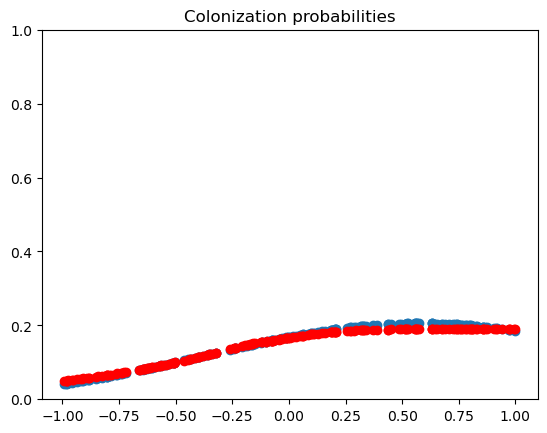

In [23]:
plt.scatter(x.numpy(), gamma.numpy())
plt.scatter(x.numpy(), gamma_hat[:, 0].cpu().detach().numpy(), color='r')
plt.title('Colonization probabilities')
plt.ylim(0, 1)
plt.show()

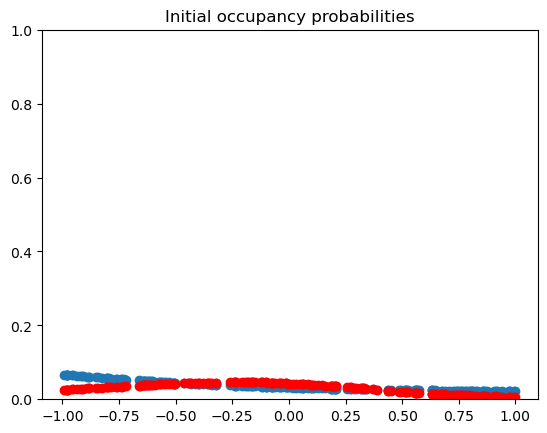

In [24]:
plt.scatter(x.numpy(), psi0.numpy())
plt.scatter(x.numpy(), psi0_hat.cpu().detach().numpy(), color='r')
plt.title('Initial occupancy probabilities')
plt.ylim(0, 1)
plt.show()

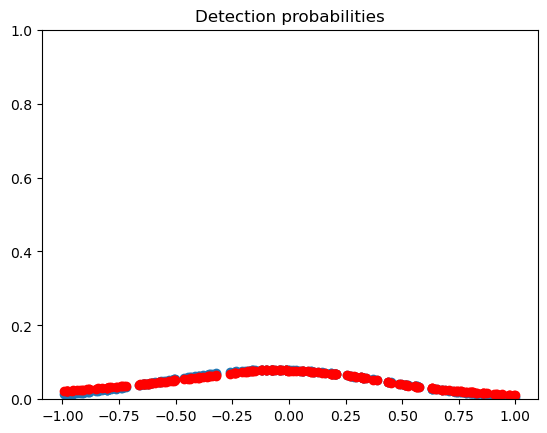

In [25]:
plt.scatter(x.numpy(), p.numpy())
plt.scatter(x.numpy(), torch.sigmoid(p_hat[:, 0]).cpu().detach().numpy(), color='r')
plt.title('Detection probabilities')
plt.ylim(0, 1)
plt.show()